In [219]:
import pandas as pd
import numpy as np
from random import randrange
import json
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

In [220]:
def json_keys_to_csv_string(json_obj, delimiter):
    csv_line=''
    for key in json_obj.keys():
        csv_line+=key
        csv_line+=delimiter
    csv_line=csv_line[:-len(delimiter)]
    return csv_line

def json_values_to_csv_string(json_obj, col_names, delimiter):
    csv_line=''
    for key in col_names:
        csv_line+=str(json_obj.get(key))
        csv_line+=delimiter
    csv_line=csv_line[:-len(delimiter)]
    return csv_line


def json_to_csv(input_file_name, output_file_name, delimiter):
    col_names = None;
    with open(input_file_name, 'r') as istr:
        with open(output_file_name, 'w') as ostr:
            for i, line in enumerate(istr):
                # Get rid of the trailing newline (if any).
                line = line.rstrip('\n')
                csv_line = None
                
                json_obj = json.loads(line)
                
                #load headers
                if col_names is None:
                    col_names = json_obj.keys()
                    csv_line = json_keys_to_csv_string(json_obj, delimiter)
                    print(csv_line, file=ostr)
                
                #load values
                csv_line = None
                csv_line = json_values_to_csv_string(json_obj, col_names, delimiter)
                print(csv_line, file=ostr)

In [221]:
def sample_csv(input_file_name, output_file_name, sample_size, total_size):
    random_indexes = set()
    while(len(random_indexes)!=sample_size):
        random_indexes.add(randrange(1,total_size+1))
        
    with open(input_file_name, 'r') as istr:
        with open(output_file_name, 'w') as ostr:
            for i, line in enumerate(istr):
                if (i in random_indexes) or (i==0):
                    line = line.rstrip('\n')
                    print(line, file=ostr)

In [222]:
def csv_to_df(input_file_name, delimiter):
    return pd.read_csv(input_file_name, delimiter=delimiter)

In [223]:
input_file_name = '/Users/rohitjoshi/thinkful/data-science-prep/reviews_Movies_and_TV_5.json'
output_file_name = '/Users/rohitjoshi/thinkful/data-science-prep/reviews_Movies_and_TV_5.csv'
#json_to_csv(input_file_name,output_file_name, '@--@')

In [224]:
input_file_name = '/Users/rohitjoshi/thinkful/data-science-prep/reviews_Movies_and_TV_5.csv'
output_file_name = '/Users/rohitjoshi/thinkful/data-science-prep/reviews_Movies_and_TV_5_sample.csv'
#sample_csv(input_file_name,output_file_name, 10000, 1500000)

In [225]:
input_file_name = '/Users/rohitjoshi/thinkful/data-science-prep/reviews_Movies_and_TV_5_sample.csv'
df = csv_to_df(input_file_name, '@--@')

/Users/rohitjoshi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [226]:
sentiment_dictionary = {}

for line in open("/Users/rohitjoshi/thinkful/data-science-prep/AFINN-111.txt"):
    word,score = line.split("\t")
    sentiment_dictionary[word]=int(score)

In [227]:
def word_count(text):
    count = 0
    for word in word_tokenize(text):
        count+=1
    return count

df['review_word_count'] = df['reviewText'].ix[:].apply(lambda x: word_count(x))

In [228]:
def afinn_score_simple(text):
    pos = 0
    neg = 0
    for word in word_tokenize(text):
        score = sentiment_dictionary.get(word, 0)
        if score > 0:
            pos+=score
        if score < 0:
            neg+=score
    return [pos, neg]

df['afinn_score'] = df['reviewText'].ix[:].apply(lambda x: afinn_score_simple(x))

In [229]:
def dominating_score(afinn_score_simple):
    if abs(afinn_score_simple[0]) > abs(afinn_score_simple[1]):
        return afinn_score_simple[0]
    elif abs(afinn_score_simple[1]) > abs(afinn_score_simple[0]):
        return afinn_score_simple[1]
    else:
        return 0.0
    
df['dominating_afinn_score'] = df['afinn_score'].ix[:].apply(lambda x: int(dominating_score(x)))

In [230]:
def sentiment_category(dominating_afinn_score):
    if dominating_afinn_score >100:
        return '5) > 100'
    elif dominating_afinn_score >50:
        return '4) 50 to 100'
    elif dominating_afinn_score >0:
        return '3) 0 to 50'
    elif dominating_afinn_score >-50:
        return '2) -50 to 0'
    else:
        return '1) < -50'
    
def sentiment_category_equals(input_category, expected_category):
    if input_category==expected_category:
        return 1
    else:
        return 0
    
df['sentiment category'] = df['dominating_afinn_score'].apply(lambda x: sentiment_category(x))
df['sentiment category < -50'] = df['sentiment category'].apply(lambda x: sentiment_category_equals(x, '1) < -50'))
df['sentiment category < -50 to 0'] = df['sentiment category'].apply(lambda x: sentiment_category_equals(x, '2) -50 to 0'))
df['sentiment category < 0 to 50'] = df['sentiment category'].apply(lambda x: sentiment_category_equals(x, '3) 0 to 50'))
df['sentiment category < 50 to 100'] = df['sentiment category'].apply(lambda x: sentiment_category_equals(x, '4) 50 to 100'))
df['sentiment category > 100'] = df['sentiment category'].apply(lambda x: sentiment_category_equals(x, '5) > 100'))


In [231]:
def helpful_category(helpful_numerator, helpful_denominator):
    if not helpful_numerator:
        return '1) Missing'
    elif (not helpful_denominator) or (int(helpful_denominator)==0):
        return '1) Missing'
    else:
        div = float(helpful_numerator)/float(helpful_denominator)
        if div > 0.75:
            return '4) > 75'
        elif div > 0.25:
            return '3) 25 to 75'
        else:
            return '2) 0 to 25'

def helpful_category_greater_than_75_percent(percent):
    if percent == '4) > 75':
        return 1
    else:
        return 0

def helpful_category_less_than_25_percent(percent):
    if percent == '2) 0 to 25':
        return 1
    else:
        return 0
    
s = df['helpful'].apply(lambda x: x.split(','))
df['helpful_numerator'] = s.apply(lambda x: x[0].replace('[',''))
df['helpful_denominator'] = s.apply(lambda x: x[1].replace(']',''))  
df['helpful_category'] = df[['helpful_numerator','helpful_denominator']].apply(lambda x: helpful_category(*x), axis=1)
df['helpful > 75%'] = df['helpful_category'].apply(lambda x: helpful_category_greater_than_75_percent(x))
df['helpful < 25%'] = df['helpful_category'].apply(lambda x: helpful_category_less_than_25_percent(x))

In [232]:
'''
This report focus on => "Exploratory Analysis of Amazon Movie Review Dataset"

I am interested in finding answers for the below questions
Q1. Study Distribution of
    1.1 Ratings
    1.2 Helpfulness
    1.3 Sentiments
    
Q2. Study Helpfulness with respect to
    2.1 Ratings
    2.2 Sentiments

Q3. Study Word Count with respect to
    3.1 Ratings
    3.2 Sentiments
    
Q4. Study Sentiments with respect to
    4.1 Rating
'''

'\nThis report focus on => "Exploratory Analysis of Amazon Movie Review Dataset"\n\nI am interested in finding answers for the below questions\nQ1. Study Distribution of\n    1.1 Ratings\n    1.2 Helpfulness\n    1.3 Sentiments\n    \nQ2. Study Helpfulness with respect to\n    2.1 Ratings\n    2.2 Sentiments\n\nQ3. Study Word Count with respect to\n    3.1 Ratings\n    3.2 Sentiments\n    \nQ4. Study Sentiments with respect to\n    4.1 Rating\n'

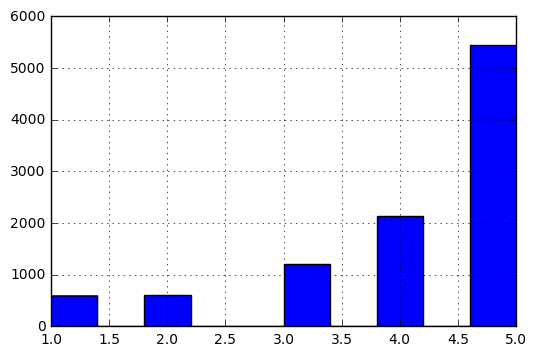

In [233]:
#1.1 Distribution of Ratings
#Conclusion:

df["overall"].hist(bins=10)

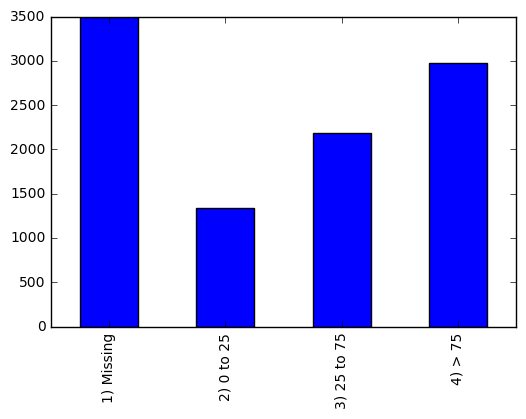

In [234]:
#1.2 Distribution of Helpfulness
#Conclusion:

df['helpful_category'].value_counts().sort_index().plot(kind="bar")

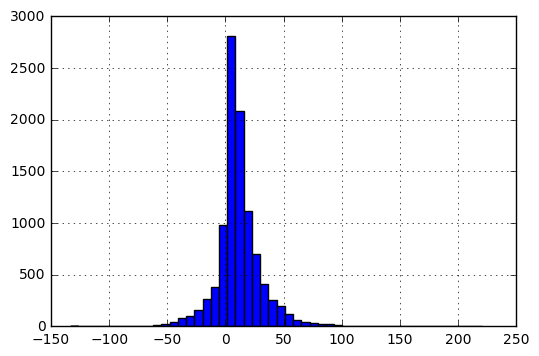

In [235]:
#1.3 Distribution of sentiments
#Conclusion:

df['dominating_afinn_score'].hist(bins=50)

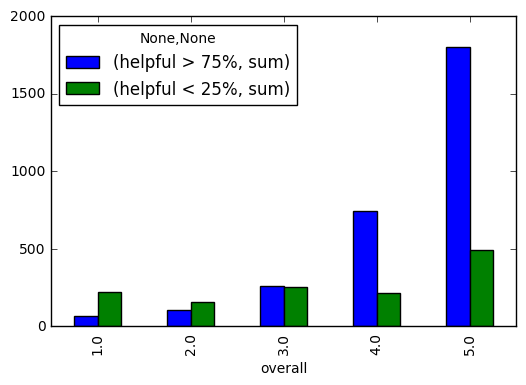

In [236]:
#2.1 How do ratings affect helpfulness
#Conclusion

rating_vs_helpfulness=df[['overall','helpful > 75%','helpful < 25%']].groupby('overall').agg(['sum'])
rating_vs_helpfulness.plot(kind='bar')

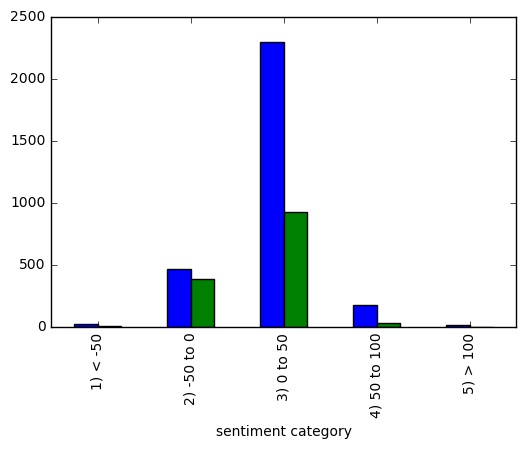

In [237]:
#2.2 How do sentiments affect helpfulness
#Conclusion

sentiment_vs_helpfulness=df[['sentiment category','helpful > 75%','helpful < 25%']].groupby('sentiment category').agg(['sum'])
sentiment_vs_helpfulness.plot(kind='bar', legend=False)

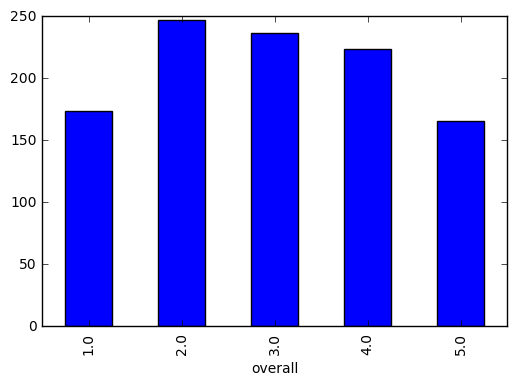

In [238]:
#3.1 How does word count vary by rating
#Conclusion: 

rating_vs_wc = df[['overall','review_word_count']].groupby('overall').agg(['mean'])
rating_vs_wc.plot(kind='bar',legend=False)

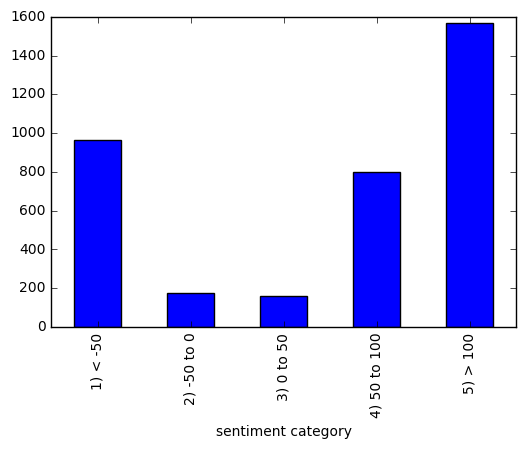

In [239]:
#3.2 How does worsd count vary by sentiments
#Conclusion

sentiment_vs_wc = df[['sentiment category','review_word_count']].groupby('sentiment category').agg(['mean'])
sentiment_vs_wc.plot(kind='bar',legend=False)

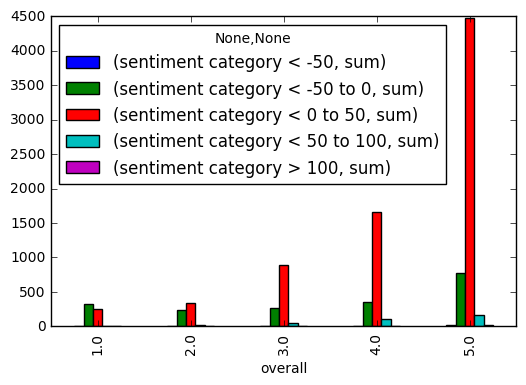

In [240]:
#4.1 How does sentiments vary by ratings
#Conclusion

sentiment_vs_rating = df[['overall','sentiment category < -50',
                         'sentiment category < -50 to 0',
                         'sentiment category < 0 to 50',
                         'sentiment category < 50 to 100',
                         'sentiment category > 100']].groupby('overall').agg(['sum'])
sentiment_vs_rating.plot(kind='bar',legend=True)